## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import random
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
from typing import List, Callable
import collections
import gymnasium as gym
from gymnasium import spaces
import pygame

## Environnement

In [57]:
# Sources:
# - https://gymnasium.farama.org/api/env/
# - https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#sphx-glr-tutorials-gymnasium-basics-environment-creation-py

class CubeEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None):
        self.size = 2 # size of rubik's cube
        self.state = np.chararray((6, self.size, self.size), unicode=True) # initialize cube config

        # a chaque fois qu'on rajoute une dim, on rajoute 6 coups possible (2 par nouveau plan, x3 car nb d'axes de l'espace)
        self.action_space = spaces.Discrete(2 * 3 * (self.size - 1))

        # render mode
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        self._position_dict = {0: "left", 1:"top", 2:"front", 3:"bottom", 4:"back", 5:"right"}
        self._color_dict = {"r": "red", "g": "green", "b": "blue", "o": "orange", "y": "yellow", "w": "black", "":"none"}
        self._action_map = { # !!!!!! WARNING !!!!!! CHANGE WITH SIZE
            0: lambda: self._horizontale_rotation(0, 1),
            1: lambda: self._horizontale_rotation(0, -1),
            2: lambda: self._verticale_rotation(0, 1),
            3: lambda: self._verticale_rotation(0, -1),
            4: lambda: self._face_rotation(0, 1),
            5: lambda: self._face_rotation(0, -1)
        }

        self.window_size = 512  # The size of the PyGame window
        self.window = None
        self.clock = None

    def _get_obs(self):
        return self.state
    
    def _get_info(self):
        """Fully known environment"""
        return {}

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

    def reset(self, seed=None, options=None):
        """Puts Rubik's cube back to fully solved"""
        self.state[0] = np.array([["o"]*self.size]*self.size)
        self.state[1] = np.array([["w"]*self.size]*self.size)
        self.state[2] = np.array([["g"]*self.size]*self.size)
        self.state[3] = np.array([["y"]*self.size]*self.size)
        self.state[4] = np.array([["r"]*self.size]*self.size)
        self.state[5] = np.array([["b"]*self.size]*self.size)

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):

        # rotate cube according to action map
        self._action_map[action]()

        # get info and everything
        terminated = self._is_solved(self.state)
        reward = self.reward(self.state)
        observation = self._get_obs()
        info = self._get_info()

        # render if necessary
        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info
    
    def reward(self, state):
        # TODO
        return int(self._is_solved(state))

    def render(self):
        """Renders one frame"""
        if self.render_mode == "rgb_array":
            return self._render_frame()
    
    def _render_frame(self):

        # init window
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (self.window_size, self.window_size)
            )
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))

        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def _is_solved(self, state):
        for i in range(6):
            if len(np.unique(state[i])) != 1: # check for all face uniqueness
                return False
        return True

    def _horizontale_rotation(self, row, direction):
        new_state = np.copy(self.state)
        if row > self.size-1:
            raise ValueError("Row number must be between 0 and ", self.size-1)
        if direction == 1: #To the right
            new_state[2, row, :] = self.state[0, row, :]
            new_state[5, row, :] = self.state[2, row, :]
            new_state[4, row, :] = self.state[5, row, :]
            new_state[0, row, :] = self.state[4, row, :]
            if row == 0:
                new_state[1] = np.rot90(self.state[1])
            elif row == self.size-1:
                new_state[3] = np.rot90(self.state[3],3)
        elif direction == -1: #To the left
            new_state[0, row, :] = self.state[2, row, :]
            new_state[2, row, :] = self.state[5, row, :]
            new_state[5, row, :] = self.state[4, row, :]
            new_state[4, row, :] = self.state[0, row, :]
            if row == 0:
                new_state[1] = np.rot90(self.state[1],3)
            elif row == self.size-1:
                new_state[3] = np.rot90(self.state[3])
        self.state = new_state

    def _verticale_rotation(self, column, direction):
        new_state = np.copy(self.state)
        if column > self.size-1:
            raise ValueError("Column number must be between 0 and ", self.size-1)
        if direction == 1: #to the top
            new_state[2, :, column] = self.state[3, :, column]
            new_state[3, :, column] = self.state[4, :, column]
            new_state[4, :, column] = self.state[1, :, column]
            new_state[1, :, column] = self.state[2, :, column]
            if column == 0:
                new_state[0] = np.rot90(self.state[0])
            elif column == self.size-1:
                new_state[5] = np.rot90(self.state[5],3)
        elif direction == -1: #to the bottom
            new_state[3, :, column] = self.state[2, :, column]
            new_state[4, :, column] = self.state[3, :, column]
            new_state[1, :, column] = self.state[4, :, column]
            new_state[2, :, column] = self.state[1, :, column]
            if column == 0:
                new_state[0] = np.rot90(self.state[0],3)
            elif column == self.size-1:
                new_state[5] = np.rot90(self.state[5])
        self.state = new_state
    
    def _face_rotation(self, face, direction):
        new_state = np.copy(self.state)
        if face > self.size-1:
            raise ValueError("Face number must be between 0 and ", self.size-1)
        if direction == 1: #clockwise
            new_state[1,self.size-1-face,:] = self.state[0,:,self.size-1-face]
            new_state[5, :, face] = self.state[1,self.size-1-face,:]
            new_state[3,face,:] = self.state[5,:,self.size-1-face]
            new_state[0,:,self.size-1-face] = self.state[3,face,:]
            if face == 0:
                new_state[2] = np.rot90(self.state[2],3)
            elif face == self.size-1:
                new_state[4] = np.rot90(self.state[4])
        elif direction == -1: #counterclockwise
            new_state[0,:,self.size-1-face] = self.state[1,self.size-1-face,:]
            new_state[1,self.size-1-face,:] = self.state[5, :, self.size-1-face]
            new_state[5, :, face] = self.state[3,face,:]
            new_state[3,face,:] = self.state[0,:,self.size-1-face]
            if face == 0:
                new_state[2] = np.rot90(self.state[2])
            elif face == self.size-1:
                new_state[4] = np.rot90(self.state[4],3)
        self.state = new_state

    def shuffle(self, n_moves):
        # TODO (not important) able to use seed
        for i in range(n_moves):
            face = np.random.randint(self.size)
            direction = np.random.choice([-1,1])
            operation = np.random.randint(3)
            if operation == 0:
                self.horizontale_rotation(face, direction)
            elif operation == 1:
                self.verticale_rotation(face, direction)
            else:
                self.face_rotation(face, direction)

In [60]:
env = CubeEnv()
env.print_2D()
env.shuffle(25)
env.print_2D()

AttributeError: 'CubeEnv' object has no attribute 'print_2D'

## Modèle utilisé comme contrôleur

In [41]:
# Source: TD6 INF581

n_input  = 6 * 6 * CUBE_SIZE * CUBE_SIZE # 6 = nombre de faces // size^2 = nombre de couleurs par face // 6 = one-hot encoding des couleurs
n_output = env.action_space.size()
n_dense  = 256 # au pif, un pax avait choisi 1024 pour le 3x3

# Setup cuda/cpu device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to CUDA if available, otherwise use CPU
print(f"PyTorch will train neural networks on {device}")

class QNetwork(torch.nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        
        self.l1 = nn.Linear(n_input, n_dense)
        self.l2 = nn.Linear(n_dense, n_dense)
        self.l3 = nn.Linear(n_dense, n_dense)
        self.l4 = nn.Linear(n_dense, n_output)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.relu(x)
        x = self.l4(x)
        return x

SyntaxError: invalid syntax (1006862838.py, line 29)

## Policy

In [37]:
class EpsilonGreedy:
    
    def __init__(self,
                 epsilon_start: float,
                 epsilon_min: float,
                 epsilon_decay: float,
                 q_network: torch.nn.Module):
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.q_network = q_network

    def __call__(self, state: np.ndarray) -> np.int64:
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        
        return torch.argmax(q_values, dim=1).item()

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [ ]:
policy=EpsilonGreedy()

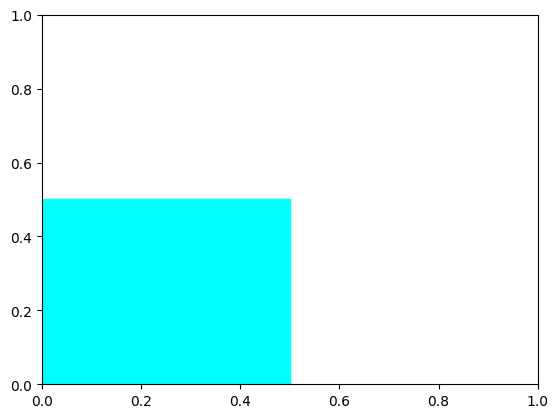

In [38]:
fig, ax = plt.subplots()
rect = patches.Rectangle((0, 0), width=.5, height=.5, color='aqua')
ax.add_patch(rect)
fig.canvas.draw()

## Learning rate scheduler

In [ ]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    
    def __init__(self, optimizer: torch.optim.Optimizer, lr_decay: float, last_epoch: int = -1, min_lr: float = 1e-6):
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self):
        return [
            max(base_lr * self.gamma ** self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

## Replay buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]:
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        return len(self.buffer)

## Train function

In [ ]:
def train_dqn2_agent(env: CubeEnv,
                     q_network: torch.nn.Module,
                     target_q_network: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     loss_fn: Callable,
                     epsilon_greedy: EpsilonGreedy,
                     device: torch.device,
                     lr_scheduler: _LRScheduler,
                     num_episodes: int,
                     gamma: float,
                     batch_size: int,
                     replay_buffer: ReplayBuffer,
                     target_q_network_sync_period: int) -> List[float]:
    iteration = 0
    episode_reward_list = []

    for episode_index in tqdm(range(1, num_episodes)):
        state, _ = env.reset()
        episode_reward = 0

        while True:

            # Get action, next_state and reward
            action = epsilon_greedy(state)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            replay_buffer.add(state, action, reward, next_state, done)

            episode_reward += reward

            # Update the q_network weights with a batch of experiences from the buffer
            if len(replay_buffer) > batch_size:
                batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = replay_buffer.sample(batch_size)

                # Convert to PyTorch tensors
                batch_states_tensor = torch.tensor(batch_states, dtype=torch.float32, device=device)
                batch_actions_tensor = torch.tensor(batch_actions, dtype=torch.long, device=device)
                batch_rewards_tensor = torch.tensor(batch_rewards, dtype=torch.float32, device=device)
                batch_next_states_tensor = torch.tensor(batch_next_states, dtype=torch.float32, device=device)
                batch_dones_tensor = torch.tensor(batch_dones, dtype=torch.float32, device=device)

                target_tensor = batch_rewards_tensor + gamma * target_q_network(batch_next_states_tensor).max(dim=1)[0] * (1 - batch_dones_tensor)
                output_tensor = q_network(batch_states_tensor).index_select(dim=1, index=batch_actions_tensor)
                loss = loss_fn(output_tensor, target_tensor)

                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                lr_scheduler.step()

            # Update the target q-network

            # Every few training steps (e.g., every 100 steps), the weights of the target network are updated with the weights of the Q-network
            if iteration % target_q_network_sync_period == 0:
                target_q_network.load_state_dict(q_network.state_dict())

            iteration += 1

            if done:
                break

            state = next_state

        episode_reward_list.append(episode_reward)
        epsilon_greedy.decay_epsilon()

    return episode_reward_list

## Train it

In [ ]:

NUMBER_OF_TRAININGS = 20
dqn2_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):
    q_network = QNetwork().to(device) # q network
    target_q_network = QNetwork().to(device) # target q network
    target_q_network.load_state_dict(q_network.state_dict()) # load same weights

    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, q_network=q_network)

    replay_buffer = ReplayBuffer(2000)

    # Train the q-network

    episode_reward_list = train_dqn2_agent(q_network,
                                           target_q_network,
                                           optimizer,
                                           loss_fn,
                                           epsilon_greedy,
                                           device,
                                           lr_scheduler,
                                           num_episodes=150,
                                           gamma=0.9,
                                           batch_size=128,
                                           replay_buffer=replay_buffer,
                                           target_q_network_sync_period=30)
    dqn2_trains_result_list[0].extend(range(len(episode_reward_list)))
    dqn2_trains_result_list[1].extend(episode_reward_list)
    dqn2_trains_result_list[2].extend([train_index for _ in episode_reward_list])

dqn2_trains_result_df = pd.DataFrame(np.array(dqn2_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn2_trains_result_df["agent"] = "DQN 2015"

# Save the action-value estimation function
torch.save(q_network, "dqn2_q_network.pth")